# Prévisions météo en Australie
### Consignes de l'itération2 : "Modélisation"

	1. Ajouter les coordonnées géographiques (Australia Cities Database | Simplemaps.com)
	2. sélection des variables avec le test du chi2
	3. Extraction du jeu de données final
	4. Tableau des performances des algo avec et sans rééquilibrage
	5. Choisir une seconde stratégie pour l’itération 2 parmi les suivantes
	• Classification des villes par clustering : création d'une nouvelle colonne catégorielle pour définir les différents types de climat selon les données climatique
	• Deep Learning
	• Séries Temporelles
	• Pluie J+3, J+7?

### Notes

	• Pour les variables avec une forte proportion de valeurs manquantes, l’algorithme KNN-Imputer (https://www.youtube.com/watch?v=QVEJJNsz-eM) permet d’imputer des NA en fonction des voisins. Les autres variables avec moins de 10% de valeurs manquantes peuvent être traitées avec la méthode interpolate.
	• Stations pour lesquelles les coordonnées géographiques sont manquantes ont été ignorées pour l'instant : ~ 50k lignes. 
	• Variables ignorées : 'Date', 'WindGustDir', 'WindDir9am' et 'WindDir3pm'.
	• Variables crées : 'Temp_Delta_MinMax', 'Humidity_Delta' et 'city_cluster'.
	• Suppression des valeurs manquantes pour 'RainToday' et 'RainTomorrow'.

**Synchro** lundi 5 septembre à 17h

**Deadline** dimanche 11 septembre

# Récupération des librairies

In [3]:
# récupération du package scikit-plot
!pip install scikit-plot

In [2]:
# récupération des librairies
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time, datetime
import scikitplot as skplt

from scipy.spatial.distance import cdist
from scipy.stats import chi2_contingency

from sklearn import ensemble, linear_model, model_selection, neighbors, preprocessing, svm

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier, Lasso, LassoCV, lasso_path, RidgeCV
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, mean_squared_error, recall_score, f1_score, precision_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, learning_curve, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from imblearn.metrics import classification_report_imbalanced
from imblearn.under_sampling import RandomUnderSampler

# Récupération et amélioration du jeu de données

## Préparation des données

In [ ]:
# chargement des données en local
from google.colab import files
uploaded = files.upload()

In [2]:
# récupération du jeu de données
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
# récupération du jeu de données sur Gdrive
# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datascientest/Meteo/weatherAUS.csv')
# df.head()

In [4]:
# taille du DataFrame initial
obs_init = df.shape[0]
var_init = df.shape[1]

print("Taille du DataFrame initial:\n")
print("Nombre d'observations : {} \n Nombre de variables : {}".format(df.shape[0], df.shape[1]))

Taille du DataFrame initial:

Nombre d'observations : 145460 
 Nombre de variables : 23


In [5]:
# suppression des doublons
df.drop_duplicates(inplace=True)

In [6]:
# détection des valeurs manquantes sur tout le dataframe
print("Pourcentage de valeurs manquantes sur tout le dataframe: \n")
df.isna().sum().sort_values(ascending=False).apply(lambda val : val/df.shape[0] * 100)

Pourcentage de valeurs manquantes sur tout le dataframe: 



Sunshine         48.009762
Evaporation      43.166506
Cloud3pm         40.807095
Cloud9am         38.421559
Pressure9am      10.356799
Pressure3pm      10.331363
WindDir9am        7.263853
WindGustDir       7.098859
WindGustSpeed     7.055548
Humidity3pm       3.098446
WindDir3pm        2.906641
Temp3pm           2.481094
RainTomorrow      2.245978
Rainfall          2.241853
RainToday         2.241853
WindSpeed3pm      2.105046
Humidity9am       1.824557
Temp9am           1.214767
WindSpeed9am      1.214767
MinTemp           1.020899
MaxTemp           0.866905
Location          0.000000
Date              0.000000
dtype: float64

 - Les variables 'Sunshine', 'Evaporation', 'Cloud3pm' et 'Cloud9am' présentent la plus forte proportion de valeurs manquantes (entre 35% et 50%).
 - Les variables "Date" et "Location" n'ont pas de valeurs manquantes.
 - Les autres variables présentent moins de 10% de valeurs manquantes.

In [7]:
# suppression des valeurs manquantes pour "RainToday" et "RainTomorrow" qui ne contiennent que deux modalités.
df.dropna(subset=['RainTomorrow', 'RainToday'], inplace=True)

In [8]:
# encodage des variables qualitatives binaires
df['RainToday'].replace({'No':0, 'Yes':1}, inplace = True)
df['RainTomorrow'].replace({'No':0, 'Yes':1}, inplace = True)

df['RainToday'] = df['RainToday'].astype('int64')
df['RainTomorrow'] = df['RainTomorrow'].astype('int64')

In [13]:
# remplacement des NANs pour les variables présentant la plus forte proportion de valeurs manquantes
# temps de calcul : ~ 1 h 30 min
X = df[['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']]
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)

model = make_pipeline(KNNImputer(), SGDClassifier())

params = {'knnimputer__n_neighbors' : [1,2,3,4]}

grid = GridSearchCV(model, param_grid=params, cv=3)
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('knnimputer', KNNImputer()),
                                       ('sgdclassifier', SGDClassifier())]),
             param_grid={'knnimputer__n_neighbors': [1, 2, 3, 4]})

In [14]:
grid.best_params_

{'knnimputer__n_neighbors': 2}

In [9]:
best_param = 2

In [10]:
# temps de calcul : ~ 20 min.
imputer = KNNImputer(n_neighbors = best_param)
df[['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']] = imputer.fit_transform(df[['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']])

In [11]:
# détection des valeurs manquantes sur tout le dataframe
print("Pourcentage de valeurs manquantes sur tout le dataframe: \n")
df.isna().sum().sort_values(ascending=False).apply(lambda val : val/df.shape[0]*100)

Pourcentage de valeurs manquantes sur tout le dataframe: 



Pressure3pm      9.780022
Pressure9am      9.761555
WindDir9am       6.861429
WindGustDir      6.508413
WindGustSpeed    6.467216
WindDir3pm       2.606775
Humidity3pm      2.486735
Temp3pm          1.863808
WindSpeed3pm     1.797751
Humidity9am      1.077514
WindSpeed9am     0.749359
Temp9am          0.465952
MinTemp          0.332417
MaxTemp          0.218060
RainToday        0.000000
Cloud9am         0.000000
Cloud3pm         0.000000
Date             0.000000
Location         0.000000
Sunshine         0.000000
Evaporation      0.000000
Rainfall         0.000000
RainTomorrow     0.000000
dtype: float64

In [12]:
# remplacement des NANs pour les variables présentant des valeurs manquantes
num_vars_with_nans = ['Pressure3pm','Pressure9am','WindGustSpeed','Humidity3pm','Temp3pm','WindSpeed3pm','Humidity9am','WindSpeed9am','Temp9am','MinTemp','MaxTemp']

index_date = pd.to_datetime(df['Date'])
df = df.set_index(index_date)

df_date = df.set_index(index_date)[num_vars_with_nans]
df_date.head()

,Pressure3pm,Pressure9am,WindGustSpeed,Humidity3pm,Temp3pm,WindSpeed3pm,Humidity9am,WindSpeed9am,Temp9am,MinTemp,MaxTemp
Date,,,,,,,,,,,
2008-12-01,1007.1,1007.7,44.0,22.0,21.8,24.0,71.0,20.0,16.9,13.4,22.9
2008-12-02,1007.8,1010.6,44.0,25.0,24.3,22.0,44.0,4.0,17.2,7.4,25.1
2008-12-03,1008.7,1007.6,46.0,30.0,23.2,26.0,38.0,19.0,21.0,12.9,25.7
2008-12-04,1012.8,1017.6,24.0,16.0,26.5,9.0,45.0,11.0,18.1,9.2,28.0
2008-12-05,1006.0,1010.8,41.0,33.0,29.7,20.0,82.0,7.0,17.8,17.5,32.3


In [13]:
# remplacement des NANs pour les variables présentant des valeurs manquantes
df_date = df_date.interpolate(method="time")

In [14]:
# remplacement des NANs pour les variables présentant des valeurs manquantes
df[num_vars_with_nans] = df_date[num_vars_with_nans]

In [15]:
df.isna().sum()

Date                0
Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir      9163
WindGustSpeed       0
WindDir9am       9660
WindDir3pm       3670
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
RainTomorrow        0
dtype: int64

In [16]:
# remplacement des valeurs manquantes en utilisant le mode
for feat in ['WindGustDir', 'WindDir9am', 'WindDir3pm'] :
    df[feat].fillna(df[feat].mode()[0], inplace=True)

In [17]:
# vérification finale sur le nombre de valeurs manquantes
df.isna().sum().sum()

0

In [18]:
# définition de nouvelles variables
df['Temp_Delta_MinMax'] = df['MaxTemp'] - df['MinTemp']
df['Humidity_Delta'] = df['Humidity3pm'] - df['Humidity9am']

In [19]:
# corrélations avec la variable cible
df.corr()['RainTomorrow'].sort_values(ascending=False)

RainTomorrow         1.000000
Humidity3pm          0.438034
RainToday            0.313097
Cloud3pm             0.290933
Humidity9am          0.256141
Humidity_Delta       0.253574
Cloud9am             0.244862
Rainfall             0.239032
WindGustSpeed        0.217533
WindSpeed9am         0.089186
WindSpeed3pm         0.085503
MinTemp              0.083992
Temp9am             -0.025635
Evaporation         -0.090469
MaxTemp             -0.159395
Temp3pm             -0.188807
Pressure3pm         -0.211297
Pressure9am         -0.229678
Temp_Delta_MinMax   -0.336272
Sunshine            -0.344986
Name: RainTomorrow, dtype: float64

In [20]:
# suppression des variables les moins corrélées à la variable cible (choix arbitraire : 'inférieur à 0.15 en valeur absolue')
df.drop(columns=['WindSpeed9am', 'WindSpeed3pm', 'MinTemp', 'Temp9am', 'Evaporation'], inplace=True)

In [21]:
# suppression de la date car ni l'année, le mois, la semaine ou la journée ne sont pas très corrélées avec la variable cible
df.drop(columns=['Date'], inplace=True)

In [22]:
# définition de la fonction mesurant le niveau de corrélation par le V de Cramer
def V_Cramer(table, N):
    stat_chi2 = chi2_contingency(table)[0]
    k = table.shape[0]
    r = table.shape[1]
    phi = max(0, (stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1, r_corr - 1))

In [23]:
# table de contingence entre entre les variables 'Humidity9am' et 'RainTomorrow'
print("Table de contingence :")
table = pd.crosstab(df['Humidity9am'], df['RainTomorrow'])

# mesure du niveau de corrélation par le V de Cramer
print("V_Cramer = {}".format(V_Cramer(table, df.shape[0])))

Table de contingence :
V_Cramer = 0.27673959015296234


In [24]:
# table de contingence entre les variables 'Humidity_Delta' et 'RainTomorrow'
print("Table de contingence :")
table = pd.crosstab(df['Humidity_Delta'], df['RainTomorrow'])

# mesure du niveau de corrélation par le V de Cramer
print("V_Cramer = {}".format(V_Cramer(table, df.shape[0])))

Table de contingence :
V_Cramer = 0.28019656157074646


In [25]:
# suppression de la variable "Humidity9am", moins corrélée à la variable cible que "Humidity_Delta"
df.drop(columns=['Humidity9am'], inplace=True)

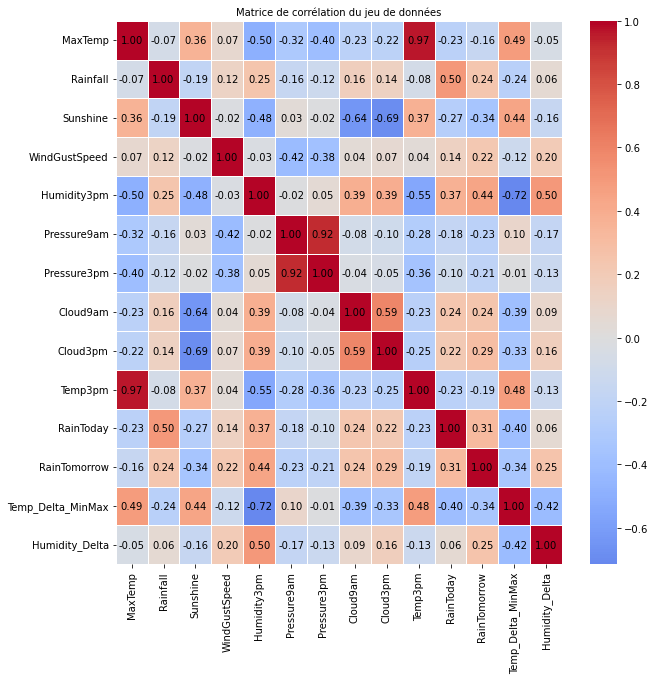

In [26]:
# création de la matrice de corrélation
fig, ax = plt.subplots(figsize=(10,10))
annot_kws={'fontsize':10,  
           'color':"k", 
           'verticalalignment':'center'}
sns.heatmap(df.corr(), linewidths=0.5, annot=True, annot_kws=annot_kws, fmt=".2f", ax=ax, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation du jeu de données', fontsize=10);

- 'Temp3pm' et 'MaxTemp' sont très fortement corrélées (+0.97)
- 'Pressure9am' et 'Pressure3pm' sont très fortement corrélées (+0.92)
- 'Humidity3pm' et 'Temp_Delta_MinMax' sont très fortement corrélées (-0.72)
- 'Sunshine' et 'Cloud3pm' sont fortement corrélées (-0.68)
- 'Sunshine' et 'Cloud9am' sont fortement corrélées (-0.62)
- 'Cloud9am' et 'Cloud3pm' sont fortement corrélées (+0.59)
- 'Humidity3pm' et 'Temp3pm' sont fortement corrélées (-0.55)



In [27]:
# table de contingence entre les variables 'Pressure9am' et 'RainTomorrow'
print("Table de contingence :")
table = pd.crosstab(df['Pressure9am'], df['RainTomorrow'])

# mesure du niveau de corrélation par le V de Cramer
print("V_Cramer = {}".format(V_Cramer(table, df.shape[0])))

Table de contingence :
V_Cramer = 0.24423121889156266


In [28]:
# table de contingence entre les variables 'Pressure3pm' et 'RainTomorrow'
print("Table de contingence :")
table = pd.crosstab(df['Pressure3pm'], df['RainTomorrow'])

# mesure du niveau de corrélation par le V de Cramer
print("V_Cramer = {}".format(V_Cramer(table, df.shape[0])))

Table de contingence :
V_Cramer = 0.22808735874790356


In [29]:
# suppression de la variable "Pressure3pm", moins corrélée à la variable cible que "Pressure9am"
df.drop(columns=['Pressure3pm'], inplace=True)

In [30]:
# table de contingence entre les variables 'Cloud9am' et 'RainTomorrow'
print("Table de contingence :")
table = pd.crosstab(df['Cloud9am'], df['RainTomorrow'])

# mesure du niveau de corrélation par le V de Cramer
print("V_Cramer = {}".format(V_Cramer(table, df.shape[0])))

Table de contingence :
V_Cramer = 0.2514090246026841


In [31]:
# table de contingence entre les variables 'Cloud3pm' et 'RainTomorrow'
print("Table de contingence :")
table = pd.crosstab(df['Cloud3pm'], df['RainTomorrow'])

# mesure du niveau de corrélation par le V de Cramer
print("V_Cramer = {}".format(V_Cramer(table, df.shape[0])))

Table de contingence :
V_Cramer = 0.30240619666711077


In [32]:
# suppression de la variable "Cloud9am", moins corrélée à la variable cible que "Cloud3pm"
df.drop(columns=['Cloud9am'], inplace=True)

In [33]:
# récupération des variables quantitatives
num_features = [col for col in df.columns if df[col].dtype != 'O']
num_data = df.select_dtypes(include='number')

print("Variables quantitatives: {}".format(num_features),'\n')
print("Nombre de variables quantitatives: {}".format(len(num_features)))

Variables quantitatives: ['MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity3pm', 'Pressure9am', 'Cloud3pm', 'Temp3pm', 'RainToday', 'RainTomorrow', 'Temp_Delta_MinMax', 'Humidity_Delta'] 

Nombre de variables quantitatives: 12


In [34]:
# cardinalité
for feature in num_features:
    print("Cardinalité de '{}': {}".format(feature, len(df[feature].unique())))

Cardinalité de 'MaxTemp': 503
Cardinalité de 'Rainfall': 679
Cardinalité de 'Sunshine': 376
Cardinalité de 'WindGustSpeed': 68
Cardinalité de 'Humidity3pm': 101
Cardinalité de 'Pressure9am': 545
Cardinalité de 'Cloud3pm': 19
Cardinalité de 'Temp3pm': 500
Cardinalité de 'RainToday': 2
Cardinalité de 'RainTomorrow': 2
Cardinalité de 'Temp_Delta_MinMax': 1094
Cardinalité de 'Humidity_Delta': 165


In [35]:
# suppression de la variable "RainToday" qui ne contient que deux modalités et se comporte donc plutôt comme une variable qualitative 
# df.drop(columns=['RainToday'], inplace=True)

In [36]:
# mise à jour de la liste des colonnes du DataFrame
# num_features = [col for col in df.columns if df[col].dtype != 'O']

In [37]:
# récupération des variables qualitatives
cat_features = [col for col in df.columns if df[col].dtype == 'O']
cat_data = df.select_dtypes(include = 'O')

print("Variables qualitatives: ", cat_features,'\n')
print("Nombre de variables qualitatives: ", len(cat_features))

Variables qualitatives:  ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'] 

Nombre de variables qualitatives:  4


In [38]:
# cardinalité
for feature in cat_features:
    print("Cardinalité de '{}': {}".format(feature, len(df[feature].unique())))

Cardinalité de 'Location': 49
Cardinalité de 'WindGustDir': 16
Cardinalité de 'WindDir9am': 16
Cardinalité de 'WindDir3pm': 16


In [39]:
# suppression des variables quantitatives "WindGustDir", "WindDir9am" et "WindDir3pm" qui présentent une cardinalité trop forte
df.drop(columns=['WindGustDir', 'WindDir9am', 'WindDir3pm'], inplace=True)

In [40]:
# mise à jour de la liste des colonnes du DataFrame
cat_features = [col for col in df.columns if df[col].dtype == 'O']

In [41]:
# transformation des variables qualitatives en variables numériques (Olivier)
# for column in cat_features:
#    l = df[column].value_counts().index.tolist() 
#    mapping = {x:y for x,y in zip(l, range(len(l)))}
#    df[column] = df[column].map(mapping) 

In [42]:
# dichotomisation (one hot encoding)
# onehot_features = ['WindGustDir', 'WindDir9am', 'WindDir3pm']

# def one_hot_encode(df, cat, prefix):
#     for col, pref in zip(cat, prefix):
#         dummy = pd.get_dummies(df[col], prefix=pref)
#         df = pd.concat([df, dummy], axis=1)
#         df = df.drop(col, axis=1)
#     return df

# df = one_hot_encode(df, onehot_features, ['wgd', 'wd9', 'wd3'])

In [43]:
# calcul des valeurs délimitant les outliers et remplacement des outliers par la valeur des limites 
for feature in ['MaxTemp','WindGustSpeed','Humidity3pm','Pressure9am','Rainfall','Temp3pm','Temp_Delta_MinMax','Humidity_Delta']:
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    IQR = q3 - q1
    lower_limit = q1 - (IQR*1.5)
    upper_limit = q3 + (IQR*1.5)
    df.loc[df[feature] < lower_limit, feature] = lower_limit
    df.loc[df[feature] > upper_limit, feature] = upper_limit

In [44]:
# remplacement des valeurs manquantes en utilisant la moyenne
# for feat in num_features :
#     df[feat].fillna(df[feat].mean(), inplace=True)

In [45]:
# Vérification des valeurs manquantes sur tout le DataFrame
# df.isnull().sum().sum()

In [46]:
# taille du DataFrame réduit
print("Taille du DataFrame réduit:\n")

print("Nombre d'observations initial: {} \n Nombre de variables initial: {} \n".format(obs_init, var_init))
print("Nombre d'observations actuel: {} \n Nombre de variables actuel: {} \n".format(df.shape[0], df.shape[1]))

print("{} % des observations retirées".format(round(100*(obs_init-df.shape[0])/obs_init,1)))
print("{} % des variables retirées".format(round(100*(var_init-df.shape[1])/var_init,1)))

Taille du DataFrame réduit:

Nombre d'observations initial: 145460 
 Nombre de variables initial: 23 

Nombre d'observations actuel: 140787 
 Nombre de variables actuel: 13 

3.2 % des observations retirées
43.5 % des variables retirées


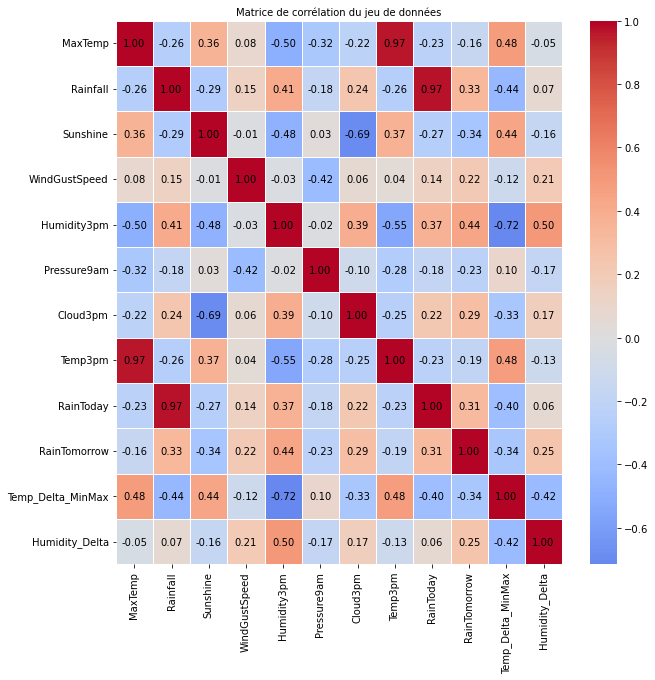

In [47]:
# création de la matrice de corrélation
fig, ax = plt.subplots(figsize=(10,10))
annot_kws={'fontsize':10,  
           'color':"k", 
           'verticalalignment':'center'}
sns.heatmap(df.corr(), linewidths=0.5, annot=True, annot_kws=annot_kws, fmt=".2f", ax=ax, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation du jeu de données', fontsize=10);

- 'Temp3pm' et 'MaxTemp' sont très fortement corrélées (+0.97)
- 'RainToday' et 'Rainfall' sont très fortement corrélées (+0.97)
- 'Humidity3pm' et 'Temp_Delta_MinMax' sont très fortement corrélées (-0.72)
- 'Sunshine' et 'Cloud3pm' sont fortement corrélées (-0.68)
- 'Humidity3pm' et 'Temp3pm' sont fortement corrélées (-0.55)


In [48]:
df.to_csv('weatherAUS_preprocessed_before_city_clust.csv')

## Classification des villes en fonction du climat

In [49]:
df = pd.read_csv("weatherAUS_preprocessed_before_city_clust.csv")

In [50]:
df.drop(columns=['Date'], inplace=True)

In [51]:
# chargement des coordonnées géographiques en local
#uploaded = files.upload()
aus_town_gps = pd.read_csv("aus_town_gps.csv",sep=",")

In [52]:
# chargement du climat en local
#uploaded = files.upload()
climatsaus = pd.read_csv("climatsAUS_v2.csv",sep=";")

In [53]:
# Pour simplifier, on regroupe les climats en 4 catégories : chaud_humide, tempéré_froid, sec et méditerranéen. On pourra ainsi faire des visualisations plus facilement.
climats_type = {'Am':'chaud_humide',
                'Aw':'chaud_humide',
                'Cfa':'chaud_humide',
                'Cfb':'tempéré_froid', 
                'Cfc':'tempéré_froid', 
                'BSh':'sec',
                'BSk':'sec',
                'Bsk':'sec', 
                'Bwh':'sec',
                'Csa':'méditerranéen',
                'Csb':'méditerranéen'              
               }

climatsaus['Clim_type']=climatsaus['Climat_Koppen'].map(climats_type)

In [54]:
df = pd.merge(df, aus_town_gps, how='left', left_on="Location",right_on="Location")
df = pd.merge(df, climatsaus, how='left', left_on="Location",right_on="Location")

In [55]:
clim_indic = pd.get_dummies(df.Clim_type, prefix='clim')
df = df.join(clim_indic).drop('Clim_type', axis=1)

In [56]:
# suppression des colonnes
df.drop(columns=['Location','Latitude', 'Longitude', 'Climat_Koppen'], inplace=True)

In [57]:
df.to_csv('weatherAUS_Rev0.csv')

In [58]:
# taille du DataFrame réduit
print("Taille du DataFrame réduit:\n")

print("Nombre d'observations initial: {} \n Nombre de variables initial: {} \n".format(obs_init, var_init))
print("Nombre d'observations actuel: {} \n Nombre de variables actuel: {} \n".format(df.shape[0], df.shape[1]))

print("{} % des observations retirées".format(round(100*(obs_init-df.shape[0])/obs_init,1)))
print("{} % des variables retirées".format(round(100*(var_init-df.shape[1])/var_init,1)))

Taille du DataFrame réduit:

Nombre d'observations initial: 145460 
 Nombre de variables initial: 23 

Nombre d'observations actuel: 140787 
 Nombre de variables actuel: 16 

3.2 % des observations retirées
30.4 % des variables retirées


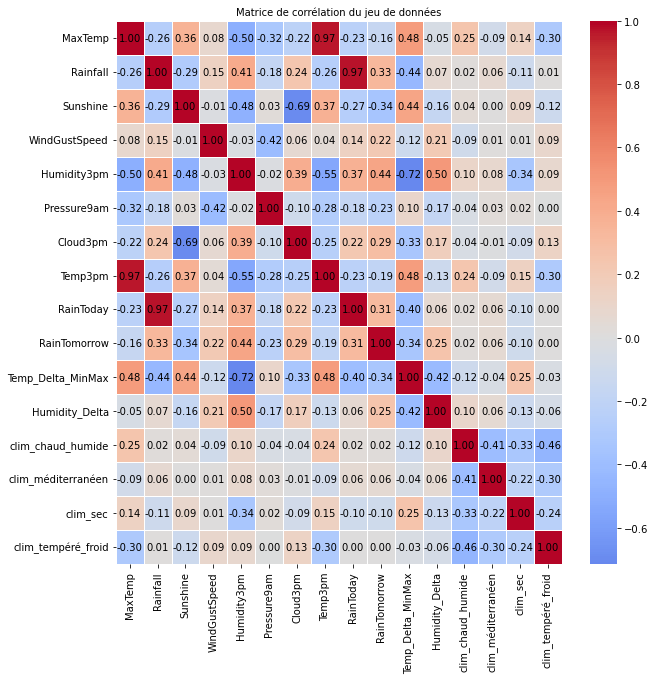

In [59]:
# création de la matrice de corrélation
fig, ax = plt.subplots(figsize=(10,10))
annot_kws={'fontsize':10,  
           'color':"k", 
           'verticalalignment':'center'}
sns.heatmap(df.corr(), linewidths=0.5, annot=True, annot_kws=annot_kws, fmt=".2f", ax=ax, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation du jeu de données', fontsize=10);

- 'Temp3pm' et 'MaxTemp' sont très fortement corrélées (+0.97)
- 'RainToday' et 'Rainfall' sont très fortement corrélées (+0.97)
- 'Humidity3pm' et 'Temp_Delta_MinMax' sont très fortement corrélées (-0.72)
- 'Sunshine' et 'Cloud3pm' sont fortement corrélées (-0.68)
- 'Humidity3pm' et 'Temp3pm' sont fortement corrélées (-0.55)

## Etude de sélection de variables

In [60]:
# normalisation de l'ensemble des données
df_copy = df.copy()
df_copy[df_copy.columns] = pd.DataFrame(StandardScaler().fit_transform(df_copy))

In [61]:
# séparation des données en une matrice de données et en un vecteur cible
data = df_copy.drop(columns=['RainTomorrow'])
target = df_copy['RainTomorrow']

In [62]:
# division des données en un ensemble d'entraînement et un ensemble de test correspondant respectivement à 80% et 20% de la quantité totale des données disponibles
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state=123)

In [63]:
y_train

71436     1.874102
16613    -0.533589
35841    -0.533589
109966   -0.533589
115370   -0.533589
            ...   
129130   -0.533589
119906   -0.533589
17730    -0.533589
28030    -0.533589
15725    -0.533589
Name: RainTomorrow, Length: 112629, dtype: float64

### Régression Ridge

In [64]:
# création d'un modèle de régression Ridge et ajustement sur données d'apprentissage
ridge_reg = RidgeCV(alphas=np.linspace(0.001, 1, 10))
ridge_reg.fit(X_train, y_train)

RidgeCV(alphas=array([0.001, 0.112, 0.223, 0.334, 0.445, 0.556, 0.667, 0.778, 0.889,
       1.   ]))

In [65]:
# alpha retenu par le modèle et scores du modèle sur l'ensemble d'entraînement et de test
print("alpha retenu par le modèle: ", ridge_reg.alpha_, "\n")

print("score du modèle sur l'ensemble d'entraînement: ", ridge_reg.score(X_train, y_train))
print("score du modèle sur l'ensemble de test: ", ridge_reg.score(X_test, y_test))

alpha retenu par le modèle:  1.0 

score du modèle sur l'ensemble d'entraînement:  0.30183189857514825
score du modèle sur l'ensemble de test:  0.30745713102652117


In [66]:
# calcul des erreurs quadratique moyenne de prédiction
ridge_pred_train = ridge_reg.predict(X_train)
ridge_pred_test = ridge_reg.predict(X_test)

mse_train = mean_squared_error(y_train, ridge_pred_train)
mse_test = mean_squared_error(y_test, ridge_pred_test)

print("Erreur quadratique moyenne de prédiction pour ridge_pred_train: ", mse_train)
print("Erreur quadratique moyenne de prédiction pour ridge_pred_test: ", mse_test)

Erreur quadratique moyenne de prédiction pour ridge_pred_train:  0.6990544435599397
Erreur quadratique moyenne de prédiction pour ridge_pred_test:  0.6890137198872981


### Régression Lasso

In [67]:
# création d'un modèle de régression Lasso et ajustement sur données d'apprentissage
lasso_reg = Lasso(alpha=0.01)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.01)

In [68]:
# coefficients estimés par le modèle
print("Coefficients estimés par le modèle: ", lasso_reg.coef_)

Coefficients estimés par le modèle:  [ 0.          0.11085993 -0.14314188  0.1521531   0.35608471 -0.12854251
  0.01647745  0.00233129  0.          0.04957764  0.         -0.
  0.010464    0.01841912 -0.04035516]


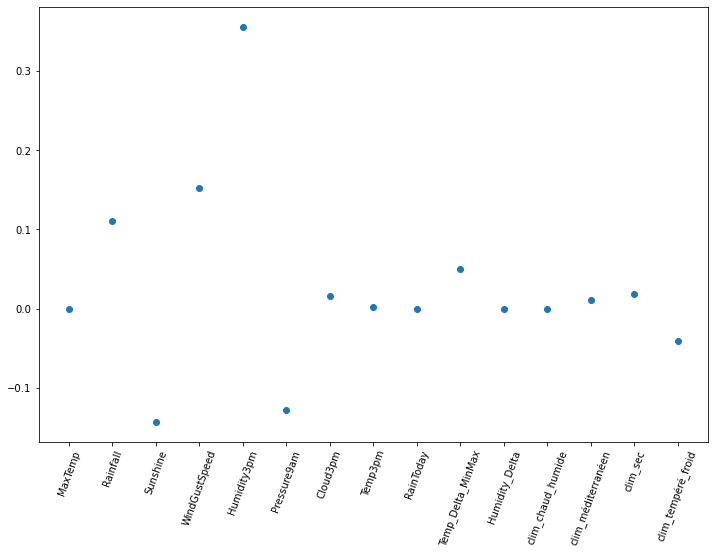

In [69]:
# graphique représentant la valeur estimée du coefficient pour chaque variable de data 
fig = plt.figure(figsize=(12,8))
plt.plot(range(len(data.columns)), lasso_reg.coef_, "o")
plt.xticks(range(len(data.columns)), data.columns.values, rotation=70);

- 10 variables sur 12 ont été sélectionnées par le modèle, avec le paramètre "alpha = 0.01". 
- Les coefficients des 2 autres variables sont estimés à 0.

In [70]:
# scores du modèle sur l'ensemble d'apprentissage et l'ensemble de test
print("Score du modèle sur l'ensemble d'apprentissage: ", lasso_reg.score(X_train, y_train))
print("Score du modèle sur l'ensemble de test: ", lasso_reg.score(X_test, y_test))

Score du modèle sur l'ensemble d'apprentissage:  0.2997084093093404
Score du modèle sur l'ensemble de test:  0.30626955235235587


In [71]:
# calcul des erreurs quadratique moyenne de prédiction
lasso_pred_train = lasso_reg.predict(X_train)
lasso_pred_test = lasso_reg.predict(X_test)

mse_train = mean_squared_error(y_train, lasso_pred_train)
mse_test = mean_squared_error(y_test, lasso_pred_test)

print("Erreur quadratique moyenne de prédiction pour lasso_pred_train: ", mse_train)
print("Erreur quadratique moyenne de prédiction pour lasso_pred_test: ", mse_test)

Erreur quadratique moyenne de prédiction pour lasso_pred_train:  0.7011806286492976
Erreur quadratique moyenne de prédiction pour lasso_pred_test:  0.690195246745207


In [72]:
# calcul des coefficients estimés en fonction des valeurs prises par alpha
alphas = (0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0)
alphas = np.linspace(0.001, 1, 10)
alpha_path, coefs_lasso, _ = lasso_path(X_train, y_train, alphas=alphas)
coefs_lasso.shape

(15, 10)

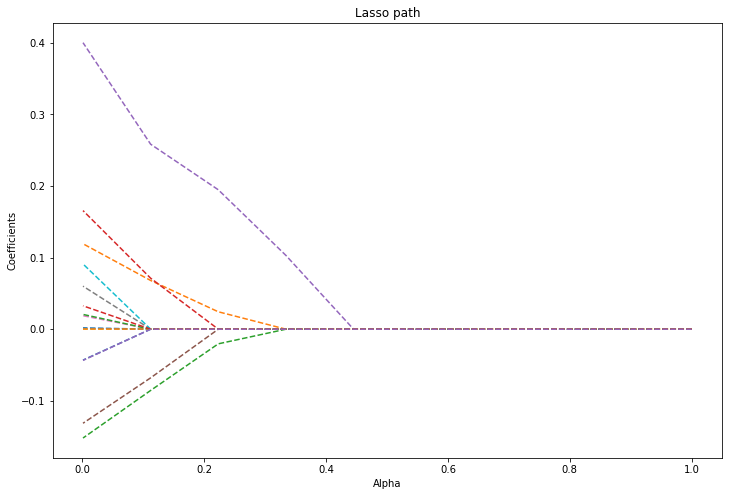

In [73]:
# courbe des valeurs du coefficient estimé en fonction des valeurs prises par alpha
fig = plt.figure(figsize=(12,8))
for i in range(coefs_lasso.shape[0]):
  plt.plot(alpha_path, coefs_lasso[i,:],'--')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso path');

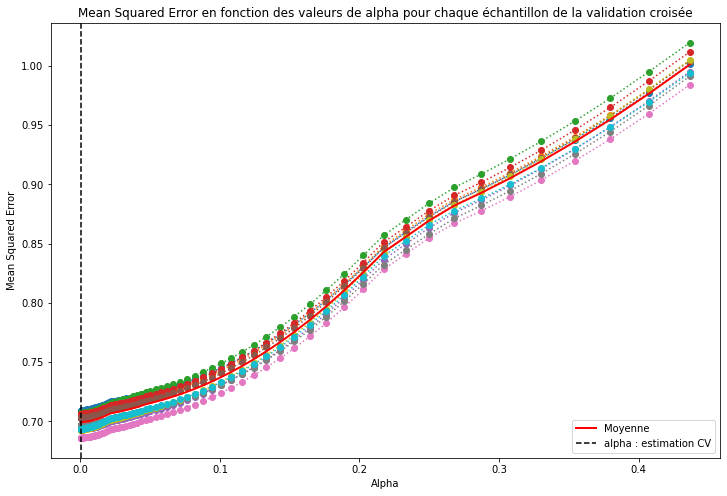

In [74]:
# recherche du alpha optimal en fonction de la performance prédictive, par validation croisée
model_lasso = LassoCV(cv=10)
model_lasso.fit(X_train, y_train)

alphas = model_lasso.alphas_

fig = plt.figure(figsize=(12,8))
plt.plot(alphas, model_lasso.mse_path_, 'o:')
plt.plot(alphas, model_lasso.mse_path_.mean(axis=1), 'r', label='Moyenne', linewidth=2)
plt.axvline(model_lasso.alpha_, linestyle='--', color='k', label='alpha : estimation CV')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error en fonction des valeurs de alpha pour chaque échantillon de la validation croisée')
plt.legend();

In [75]:
# score et MSE obtenu sur l'echantillon de test par le modèle 'model_lasso'
print("score du modèle sur l'ensemble d'apprentissage: ", model_lasso.score(X_train, y_train)) 
print("score du modèle sur l'ensemble de test: ", model_lasso.score(X_test, y_test))

model_lasso_pred_train = model_lasso.predict(X_train)
model_lasso_pred_test = model_lasso.predict(X_test)

mse_train = mean_squared_error(y_train, model_lasso_pred_train)
mse_test = mean_squared_error(y_test, model_lasso_pred_test)

print("\n Erreur quadratique moyenne de prédiction pour model_lasso_pred_train: ", mse_train)
print("Erreur quadratique moyenne de prédiction pour model_lasso_pred_test: ", mse_test)

score du modèle sur l'ensemble d'apprentissage:  0.3017985258137236
score du modèle sur l'ensemble de test:  0.3075387419054014

 Erreur quadratique moyenne de prédiction pour model_lasso_pred_train:  0.6990878586889326
Erreur quadratique moyenne de prédiction pour model_lasso_pred_test:  0.6889325248916384


### Embedded Method




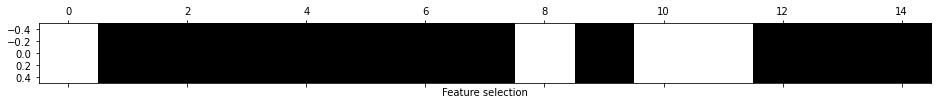

In [76]:
# ajustement du selecteur sur le jeu d'entraînement 
lasso = Lasso(alpha=0.01)
sel = SelectFromModel(estimator=lasso, threshold=1e-10)
sel.fit(X_train, y_train)

# représentation graphique des features sélectionnées 
mask = sel.get_support()
plt.matshow(mask.reshape(1,-1), cmap='gray_r')
plt.xlabel('Feature selection');

In [77]:
# création d'une grille de paramètres pour alpha et ajustement de la grid search sur le jeu d'entraînement
alpha_grid = {'alpha' : np.linspace(0.001, 1, 10)}
crossval  = KFold(n_splits=3, random_state=2, shuffle=True)

search = GridSearchCV(estimator=lasso, param_grid=alpha_grid, scoring='neg_mean_squared_error', cv=crossval)
search.fit(X_train, y_train)
print("Meilleur paramètre retenu par la grid search: ", search.best_params_)

Meilleur paramètre retenu par la grid search:  {'alpha': 0.001}


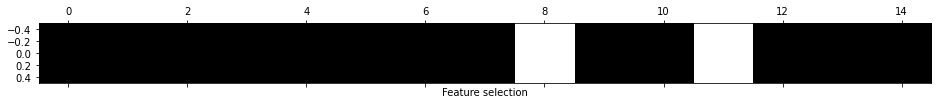

In [78]:
# récupération du jeu de features sélectionnées
sel = SelectFromModel(estimator=search.best_estimator_, threshold=1e-10, prefit=True)

# représentation graphique des features sélectionnées 
mask = sel.get_support()
plt.matshow(mask.reshape(1,-1), cmap='gray_r')
plt.xlabel('Feature selection');

In [79]:
#création de la liste des variables sélectionnées
select_feats = []
for feats, select in zip(X_train.columns, mask):
    if select == True:
        select_feats.append(feats)

In [80]:
# select_feats = X_train.columns[mask]
X_train.columns[mask]

Index(['MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity3pm',
       'Pressure9am', 'Cloud3pm', 'Temp3pm', 'Temp_Delta_MinMax',
       'Humidity_Delta', 'clim_méditerranéen', 'clim_sec',
       'clim_tempéré_froid'],
      dtype='object')

## Sélection de variables avec SelectKBest

In [81]:
df = pd.read_csv("weatherAUS_Rev0.csv", index_col=0)
df_copy = df.copy()
# séparation des données en une matrice de données et en un vecteur cible
data = df_copy.drop(columns=['RainTomorrow'])
target = df_copy['RainTomorrow']
# division des données en un ensemble d'entraînement et un ensemble de test correspondant respectivement à 80% et 20% de la quantité totale des données disponibles
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state=123)

In [82]:
#SelectKBest nécessite des données positives pour le chi2
X_Kbest = pd.DataFrame(MinMaxScaler().fit_transform(X_train), columns=X_train.columns)

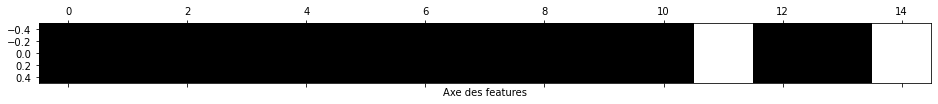

In [83]:
sel = SelectKBest(score_func = chi2, k=13)
sel.fit(X_Kbest, y_train)
mask = sel.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');

In [84]:
select_feats = X_train.columns[mask]
X_train.columns[mask]

Index(['MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity3pm',
       'Pressure9am', 'Cloud3pm', 'Temp3pm', 'RainToday', 'Temp_Delta_MinMax',
       'Humidity_Delta', 'clim_méditerranéen', 'clim_sec'],
      dtype='object')

## Sauvegarde du jeu de données

In [85]:
df.to_csv('weatherAUS_preprocessed.csv')

# Modèles de classification par apprentissage supervisé

In [ ]:
# chargement des données en local
from google.colab import files
uploaded = files.upload()

In [3]:
# récupération du jeu de données sauvegardé
df = pd.read_csv('weatherAUS_preprocessed.csv', index_col=0)
df.head()

,MaxTemp,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,RainToday,RainTomorrow,Temp_Delta_MinMax,Humidity_Delta,clim_chaud_humide,clim_méditerranéen,clim_sec,clim_tempéré_froid
0,22.9,0.6,0.15000,44.0,22.0,1007.7,8.00000,21.8,0,0,9.5,-49.0,1,0,0,0
1,25.1,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,0,0,17.7,-19.0,1,0,0,0
2,25.7,0.0,11.70000,46.0,30.0,1007.6,2.00000,23.2,0,0,12.8,-8.0,1,0,0,0
3,28.0,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,0,0,18.8,-29.0,1,0,0,0
4,32.3,1.0,2.55000,41.0,33.0,1010.8,8.00000,29.7,0,0,14.8,-49.0,1,0,0,0


In [4]:
#récupération du jeu de données sur Gdrive
# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datascientest/Meteo/weatherAUS_preprocessed.csv')
# df.head()

In [6]:
select_feats = ['MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity3pm',
       'Pressure9am', 'Cloud3pm', 'Temp3pm', 'RainToday', 'Temp_Delta_MinMax',
       'Humidity_Delta', 'clim_méditerranéen', 'clim_sec']

In [7]:
# séparation des données en une matrice de données et en un vecteur cible
data = df[select_feats]
target = df['RainTomorrow']

In [8]:
# division des données en un ensemble d'entraînement et un ensemble de test correspondant respectivement à 80% et 20% de la quantité totale des données disponibles
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state=123)

In [9]:
# distribution de la variable cible dans l'ensemble d'entraînement
y_train.value_counts(normalize=True)

0    0.777988
1    0.222012
Name: RainTomorrow, dtype: float64

In [10]:
# distribution de la variable cible dans l'ensemble de test
y_test.value_counts(normalize=True)

0    0.779956
1    0.220044
Name: RainTomorrow, dtype: float64

In [11]:
# oversampling des données
# rOs = RandomOverSampler()
# X_ro, y_ro = rOs.fit_resample(X_train, y_train)
# print("Classes échantillon oversampled :", dict(pd.Series(y_ro).value_counts()))

In [12]:
# undersampling des données
rUs = RandomUnderSampler()
X_train_ru, y_train_ru = rUs.fit_resample(X_train, y_train)
print("Classes échantillon undersampled :", dict(pd.Series(y_train_ru).value_counts()))

Classes échantillon undersampled : {0: 25005, 1: 25005}


In [13]:
# distribution de la variable cible dans l'ensemble de test
y_train_ru.value_counts(normalize=True)

0    0.5
1    0.5
Name: RainTomorrow, dtype: float64

In [14]:
# paramètre à initialiser pour calculer les performances des algo avec et sans rééquilibrage
param_ru = ''

if param_ru == 'under_sample':
    X_train = X_train_ru
    y_train = y_train_ru

In [15]:
# standardisation des données
scaler = StandardScaler()
# scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Régression Logistique

In [16]:
# définition du modèle
clf_lr  = LogisticRegression()

param_grid_lr = {'solver' : ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'], 
                 'C' : np.linspace(0.1,1,10)}

gcv_lr = GridSearchCV(clf_lr, param_grid_lr, cv=3)

In [17]:
start_time = time.time()

# entraînement (~ 25 sec.)
gcv_lr.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_lr.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_lr.best_params_, "\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_lr.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_lr.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print('\n', classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'C': 0.1, 'solver': 'lbfgs'} 

Accuracy Score: 0.8435258185950707 

Train Data Score: 0.8394995960187873
Test Data Score: 0.8435258185950707

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            20726  1236
1             3170  3026

               precision    recall  f1-score   support

           0       0.87      0.94      0.90     21962
           1       0.71      0.49      0.58      6196

    accuracy                           0.84     28158
   macro avg       0.79      0.72      0.74     28158
weighted avg       0.83      0.84      0.83     28158

Running Time: 0:01:15.240531


- la méthode de régression logistique ne fait pas l'objet de sur-apprentissage.
- la sensibilité (taux de vrais positifs) vaut 0.76.
- la spécificité (taux de vrais négatifs) vaut 0.79.
- le F1-score concernant la classe '0' de la variable RainTomorrow est bon (0.85).
- le F1-score concernant la classe '1' de la variable RainTomorrow est faible (0.61).

In [18]:
cv_scores = cross_val_score(gcv_lr, X_train_scaled, y_train, cv=3, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))
print('Average cross-validation score: {}'.format(cv_scores.mean()))

Cross-validation scores:[0.83826546 0.83930426 0.84116879]
Average cross-validation score: 0.839579504390521


- Le score de la méthode de régression logistique est en moyenne de : 0.77.

In [19]:
pd.DataFrame([f1_score(y_test, y_pred),recall_score(y_test, y_pred),precision_score(y_test, y_pred)],
             index=['f1','recall','precision'], columns=['scores_clf_lr_' + param_ru]).to_csv('scores_clf_lr_' + param_ru + '.csv')

In [102]:
# courbe ROC (Receiver Operaing Characteristic) pour le modèle de régression logistique
y_pred_logreg_proba = gcv_lr.predict_proba(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_logreg_proba[:,1])

In [103]:
# aire sous la courbe ROC
roc_auc = auc(fpr, tpr)
print("Aire sous la courbe =", roc_auc)

Aire sous la courbe = 0.8556330557229287


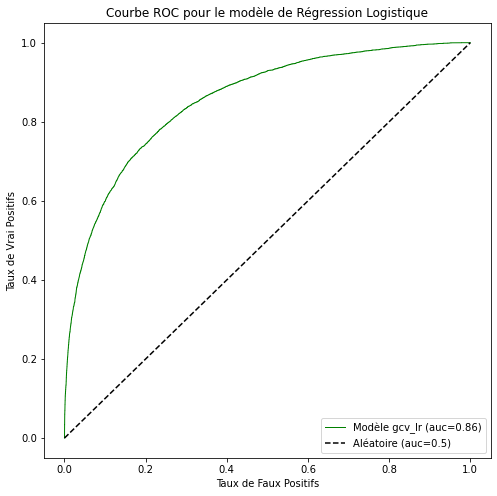

In [104]:
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, '-g', linewidth=1, label='Modèle gcv_lr (auc=%0.2f)' %roc_auc)
plt.plot([0,1], [0,1], 'k--', label='Aléatoire (auc=0.5)')
plt.title('Courbe ROC pour le modèle de Régression Logistique')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrai Positifs')
plt.legend(loc="lower right");


- La courbe ROC est l'outil idéal pour résumer la performance d'un classifieur binaire en fonction de tous les seuils possibles. Elle évite un long travail de prédictions de classes pour différents seuils, et d'évaluation de la matrice de confusion pour chacun de ces seuils.
- Graphiquement, la mesure ROC est représentée sous la forme d'une courbe qui donne le taux de vrais positifs (la sensibilité), en fonction du taux de faux positifs (l'antispécificité).
- Plus la courbe se rapproche du point (0,1), meilleures sont les prédictions. Un modèle avec une sensibilité et une spécificité égales à 1 est considéré comme parfait.



## Forêts Aléatoires

In [20]:
# définition du modèle
clf_rf  = RandomForestClassifier() # les forêts aléatoires ne gèrent pas les variables qualitatives

param_grid_rf  = [{'n_estimators' : [10, 50, 100],
                   'min_samples_leaf' : np.arange(1,6,1),
                   'max_features' : ['sqrt', 'log2']}]

gcv_rf = GridSearchCV(clf_rf, param_grid_rf)

In [21]:
start_time = time.time()

# entraînement (~ 6 min.)
gcv_rf.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_rf.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_rf.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_rf.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_rf.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print(classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 100} 

Accuracy Score: 0.8552454009517722 

Train Data Score: 0.9431940264052775
Test Data Score: 0.8552454009517722

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            20960  1002
1             3074  3122
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     21962
           1       0.76      0.50      0.61      6196

    accuracy                           0.86     28158
   macro avg       0.81      0.73      0.76     28158
weighted avg       0.85      0.86      0.84     28158

Running Time: 0:16:58.268273


- la méthode de forêt aléatoire fait l'objet de sur-apprentissage.
- la sensibilité (taux de vrais positifs) vaut 0.79.
- la spécificité (taux de vrais négatifs) vaut 0.81.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est bon (0.87).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.64).

In [107]:
# temps d'exécution : ~ 18 min.
cv_scores = cross_val_score(gcv_rf, X_train_scaled, y_train, cv=3, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))
print('Average cross-validation score: {}'.format(cv_scores.mean()))

Cross-validation scores:[0.77954409 0.78356329 0.7845231 ]
Average cross-validation score: 0.7825434913017396


- Le score de la méthode des forêts aléatoires est en moyenne de : 0.80.

In [22]:
pd.DataFrame([f1_score(y_test, y_pred),recall_score(y_test, y_pred),precision_score(y_test, y_pred)],
             index=['f1','recall','precision'], columns=['scores_clf_rf_' + param_ru]).to_csv('scores_clf_rf_' + param_ru + '.csv')

In [109]:
# probabilités pour X_test_scaled d'appartenir à chacune des deux classes
y_probas = gcv_rf.predict_proba(X_test_scaled)

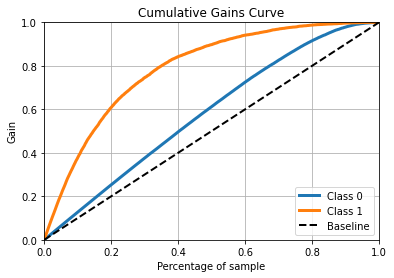

In [110]:
# courbe de gain cumulée
skplt.metrics.plot_cumulative_gain(y_test, y_probas);

- L'axe horizontal représente les individus de l'échantillon test.
- L'axe vertical représente la variable cible 'RainTomorrow'.

## Support Vector Machine

In [111]:
# définition du modèle
clf_svm = svm.SVC()

# le temps de calcul est élevé lors d'une régularisation des paramètres de la fonction noyau
param_grid_svm = {'kernel' : ['rbf','linear','poly'],
                  'gamma' : [0.001, 0.1, 0.5]}

gcv_svm = GridSearchCV(clf_svm, param_grid_svm)

In [112]:
start_time = time.time()

# entraînement (~ 1h)
grille = gcv_svm.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_svm.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_svm.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_svm.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_svm.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print(classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'gamma': 0.1, 'kernel': 'rbf'} 

Accuracy Score: 0.7958306697918887 

Train Data Score: 0.7916016796640671
Test Data Score: 0.7958306697918887

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            17595  4367
1             1382  4814
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     21962
           1       0.52      0.78      0.63      6196

    accuracy                           0.80     28158
   macro avg       0.73      0.79      0.74     28158
weighted avg       0.84      0.80      0.81     28158

Running Time: 3:34:36.021946


- la méthode SVM fait l'objet de sur-apprentissage.
- la sensibilité (taux de vrais positifs) vaut 0.79.
- la spécificité (taux de vrais négatifs) vaut 0.79.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est bon (0.86).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.63).

In [113]:
cv_scores = cross_val_score(gcv_svm, X_train_scaled, y_train, cv=3, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))
print('Average cross-validation score: {}'.format(cv_scores.mean()))

Cross-validation scores:[0.78008398 0.78374325 0.78314337]
Average cross-validation score: 0.7823235352929414


- Le score de la méthode SVM est en moyenne de : 0.79.

In [114]:
pd.DataFrame([f1_score(y_test, y_pred),recall_score(y_test, y_pred),precision_score(y_test, y_pred)],
             index=['f1','recall','precision'], columns=['scores_clf_svm_' + param_ru]).to_csv('scores_clf_svm_' + param_ru + '.csv')

In [115]:
print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params','mean_test_score']])

                                 params  mean_test_score
0     {'gamma': 0.001, 'kernel': 'rbf'}         0.771426
1  {'gamma': 0.001, 'kernel': 'linear'}         0.770646
2    {'gamma': 0.001, 'kernel': 'poly'}         0.691122
3       {'gamma': 0.1, 'kernel': 'rbf'}         0.782224
4    {'gamma': 0.1, 'kernel': 'linear'}         0.770646
5      {'gamma': 0.1, 'kernel': 'poly'}         0.774245
6       {'gamma': 0.5, 'kernel': 'rbf'}         0.782004
7    {'gamma': 0.5, 'kernel': 'linear'}         0.770646
8      {'gamma': 0.5, 'kernel': 'poly'}         0.778784


In [116]:
# courbe d'apprentissage du modèle (prend beaucoup trop de temps)
# train_sizes, train_scores, valid_scores = learning_curve(svm.SVC(kernel='linear', C=1), data, target, train_sizes=[50, 80, 110, 140], cv=5)
# plt.xlabel("Training examples")
# plt.ylabel("Score")

# train_sizes = [50, 70, 80, 100, 110, 118]
# train_sizes, train_scores, test_scores = learning_curve(gcv_svm, data, target, n_jobs=4, train_sizes=train_sizes)

# train_score_mean = np.mean(train_scores, axis=1)
# train_score_std = np.std(train_scores, axis=1)
# test_score_mean = np.mean(test_scores, axis=1)
# test_score_std = np.std(test_scores, axis=1)

# plt.grid()
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
# plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
# plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# plt.legend(loc="best");

## K-plus proches voisins

In [23]:
# définition du modèle
clf_knn = neighbors.KNeighborsClassifier()

param_grid_knn = {'n_neighbors' : np.arange(1,41,1),
                  'metric' : ['minkowski','manhattan','chebyshev']}

gcv_knn = GridSearchCV(clf_knn, param_grid_knn)

In [24]:
start_time = time.time()

# entraînement (~ 20 min.)
gcv_knn.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_knn.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_knn.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_knn.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_knn.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print(classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'metric': 'manhattan', 'n_neighbors': 39} 

Accuracy Score: 0.8520846651040557 

Train Data Score: 0.8537321648953644
Test Data Score: 0.8520846651040557

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            21012   950
1             3215  2981
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     21962
           1       0.76      0.48      0.59      6196

    accuracy                           0.85     28158
   macro avg       0.81      0.72      0.75     28158
weighted avg       0.84      0.85      0.84     28158

Running Time: 3:01:31.312568


- la méthode des K-plus proches voisins ne fait pas l'objet de sur-apprentissage.
- la sensibilité (taux de vrais positifs) vaut 0.77.
- la spécificité (taux de vrais négatifs) vaut 0.80.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est bon (0.86).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.62).

In [120]:
# temps de calcul : ~ 35 min.
cv_scores = cross_val_score(gcv_knn, X_train_scaled, y_train, cv=3, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))
print('Average cross-validation score: {}'.format(cv_scores.mean()))

Cross-validation scores:[0.77240552 0.774985   0.77780444]
Average cross-validation score: 0.7750649870025995


- Le score de la méthode KNN est en moyenne de : 0.78.

In [25]:
pd.DataFrame([f1_score(y_test, y_pred),recall_score(y_test, y_pred),precision_score(y_test, y_pred)],
             index=['f1','recall','precision'], columns=['scores_clf_knn_' + param_ru]).to_csv('scores_clf_knn_' + param_ru + '.csv')

In [122]:
# scores de 3 modèles utilisant respectivement les matrices de Minkowski, Manhattan et Chebyshev pour des valeurs de k allant de 1 à 40
# temps de calcul : ~ 12 min.
score_minko = []
score_man = []
score_cheb = []

for k in range(1,41):
  knn = neighbors.KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train_scaled, y_train)
  score_minko.append(knn.score(X_test_scaled, y_test))

for k in range(1,41):
  knn = neighbors.KNeighborsClassifier(n_neighbors=k, metric='manhattan')
  knn.fit(X_train_scaled, y_train)
  score_man.append(knn.score(X_test_scaled, y_test))

for k in range(1,41):
  knn = neighbors.KNeighborsClassifier(n_neighbors=k, metric='chebyshev')
  knn.fit(X_train_scaled, y_train)
  score_cheb.append(knn.score(X_test_scaled, y_test))

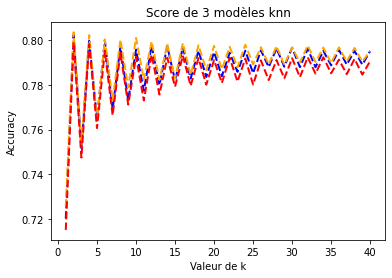

In [123]:
# affichage des listes crées en fonction de k
plt.title("Score de 3 modèles knn")
plt.plot(range(1,41), score_minko, color='blue', linestyle='dashed', lw=2, label='Minkowski')
plt.plot(range(1,41), score_man, color='orange', linestyle='dashed', lw=2, label='Manhattan')
plt.plot(range(1,41), score_cheb, color='red', linestyle='dashed', lw=2, label='Chebyshev')
plt.xlabel("Valeur de k")
plt.ylabel("Accuracy")
plt.legend;

## Arbres de décision

In [26]:
# définition du modèle
clf_dt = DecisionTreeClassifier()

param_grid_dt = {'criterion' : ['entropy','gini'], 
                 'max_depth' : np.arange(2,6,1)}

gcv_dt = GridSearchCV(clf_dt, param_grid_dt)

In [27]:
start_time = time.time()

# entraînement
gcv_dt.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_dt.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_dt.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_dt.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_dt.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print(classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'criterion': 'gini', 'max_depth': 5} 

Accuracy Score: 0.8392996661694723 

Train Data Score: 0.8385140594340712
Test Data Score: 0.8392996661694723

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            20828  1134
1             3391  2805
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     21962
           1       0.71      0.45      0.55      6196

    accuracy                           0.84     28158
   macro avg       0.79      0.70      0.73     28158
weighted avg       0.83      0.84      0.83     28158

Running Time: 0:00:08.332925


- la méthode des arbres de décision ne fait pas l'objet de sur-apprentissage.
- la sensibilité (taux de vrais positifs) vaut 0.75.
- la spécificité (taux de vrais négatifs) vaut 0.77.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est bon (0.84).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.59).

In [126]:
# importance des variables
clf_dt = gcv_dt.best_estimator_
clf_dt.fit(X_train_scaled,y_train)

feats = {}
for feature, importance in zip(df.columns, clf_dt.feature_importances_):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0:'Importance'})
importances.sort_values(by='Importance', ascending=False).head(8)

,Importance
Humidity3pm,0.675205
Sunshine,0.115665
WindGustSpeed,0.087159
Pressure9am,0.073247
Rainfall,0.039847
Humidity_Delta,0.003427
Temp_Delta_MinMax,0.002319
MaxTemp,0.001718


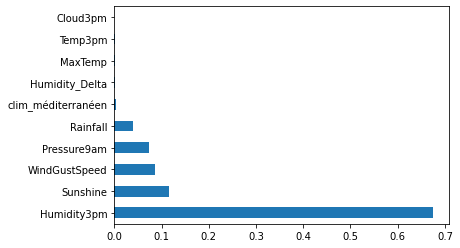

In [127]:
# importance des variables
feature_imp = pd.Series(clf_dt.feature_importances_,index=data.columns)
feature_imp.nlargest(10).plot(kind='barh');

In [128]:
cv_scores = cross_val_score(gcv_dt, X_train_scaled, y_train, cv=3, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))
print('Average cross-validation score: {}'.format(cv_scores.mean()))

Cross-validation scores:[0.75938812 0.75944811 0.755009  ]
Average cross-validation score: 0.7579484103179364


- Le score de la méthode DT est en moyenne de : 0.76.

In [28]:
pd.DataFrame([f1_score(y_test, y_pred),recall_score(y_test, y_pred),precision_score(y_test, y_pred)],
             index=['f1','recall','precision'], columns=['scores_clf_dt_' + param_ru]).to_csv('scores_clf_dt_' + param_ru + '.csv')

# Résumé des performances

In [136]:
scores_clf_dt_under_sample = pd.read_csv('scores_clf_dt_under_sample.csv', index_col=0)
scores_clf_knn_under_sample = pd.read_csv('scores_clf_knn_under_sample.csv', index_col=0)
scores_clf_svm_under_sample = pd.read_csv('scores_clf_svm_under_sample.csv', index_col=0)
scores_clf_rf_under_sample = pd.read_csv('scores_clf_rf_under_sample.csv', index_col=0)
scores_clf_lr_under_sample = pd.read_csv('scores_clf_lr_under_sample.csv', index_col=0)

In [141]:
result_under_sample = pd.concat([scores_clf_dt_under_sample, scores_clf_knn_under_sample,scores_clf_svm_under_sample,
                    scores_clf_rf_under_sample,scores_clf_lr_under_sample], axis=1)

In [142]:
result_under_sample

,scores_clf_dt_under_sample,scores_clf_knn_under_sample,scores_clf_svm_under_sample,scores_clf_rf_under_sample,scores_clf_lr_under_sample
f1,0.592391,0.617278,0.626130,0.621807,0.601462
recall,0.736281,0.773241,0.776953,0.783731,0.763719
precision,0.495546,0.513670,0.524344,0.515335,0.496069


In [29]:
scores_clf_dt_ = pd.read_csv('scores_clf_dt_.csv', index_col=0)
scores_clf_knn_ = pd.read_csv('scores_clf_knn_.csv', index_col=0)
scores_clf_rf_ = pd.read_csv('scores_clf_rf_.csv', index_col=0)
scores_clf_lr_ = pd.read_csv('scores_clf_lr_.csv', index_col=0)

In [30]:
result_ = pd.concat([scores_clf_dt_, scores_clf_knn_,
                    scores_clf_rf_,scores_clf_lr_], axis=1)

In [31]:
result_

,scores_clf_dt_,scores_clf_knn_,scores_clf_rf_,scores_clf_lr_
f1,0.553527,0.588723,0.605039,0.578696
recall,0.452711,0.481117,0.503873,0.488380
precision,0.712110,0.758331,0.757032,0.709995
